# **Combined Cases**

## **1. Import Libraries**

In [31]:
import pandas as pd # pandas is ised to load and manipulate data and for One-Hot Encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors # 
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit # split data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # support vector machine classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # cross validation
from sklearn.metrics import confusion_matrix # create confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # draw confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA # perform PCA to plot the data

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

import pickle  
import joblib 


# import matlab data
from scipy.io import loadmat

## **2. Function**

In [32]:
def load_subject_data(subject_number):
    # [INPUT: EEG & ECG data] load the .mat file
    data_path = f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/EEG_ECG_Features/EEG_ECG_Features_subject{subject_number}.mat'
    data = loadmat(data_path)
    ECG_features = data['ECG_features']
    EEG_features = data['EEG_features']
    channelList_pre = data['channelList'][0]
    channelList = []
    for i in range(len(channelList_pre)):
        channelList.append(channelList_pre[i][0])

    # [OUTPUT: ORD] load the .xlsx file
    ord_filepath = 'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels.xlsx'
    xl = pd.ExcelFile(ord_filepath)
    sheet_name = xl.sheet_names[subject_number-1] # access the subject's sheet by index
    ord_60min = pd.read_excel(ord_filepath, sheet_name=sheet_name)
    
    return ECG_features, EEG_features, ord_60min, channelList

In [33]:
def ECG_dataframe(subject, ECG_features_allcases):
    ECG_features_py = []
    
    # Loop through each struct in the struct array
    for i in range(ECG_features_allcases[subject].shape[0]):  # Adjusted loop for Nx1 struct array
        struct = ECG_features_allcases[subject][i, 0]
        scalar_dict = {
            'Index': struct['Index'][0, 0],
            'VLF': struct['VLF'][0, 0],
            'LF': struct['LF'][0, 0],
            'HF': struct['HF'][0, 0],
            'LFHF': struct['LFHF'][0, 0],
            'pLF': struct['pLF'][0, 0],
            'pHF': struct['pHF'][0, 0]
        }
        ECG_features_py.append(scalar_dict)

    # Convert scalar values to DataFrame
    ECG_features_df = pd.DataFrame(ECG_features_py)
    
    return ECG_features_df

In [34]:
def EEG_dataframe_list(subject, EEG_features_allcases):
    
    EEG_features_df_list = []

    numEEGchannels = EEG_features_allcases[subject].shape[1]
    numEEGepochs = EEG_features_allcases[subject].shape[0]
    EEG_featurelist = ['Epoch', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative', 'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio']

    # Assuming struct_array is of shape (139, 12), iterate through each struct
    for channel in range(numEEGchannels):  # for j in range(12)
        channelfeatures = []
        for epoch in range(numEEGepochs):  # for i in range(139)
            epochfeatures = {field: EEG_features_allcases[subject][epoch, channel][field][0,0] for field in EEG_featurelist}
            channelfeatures.append(epochfeatures)
        
        channelfeatures_df = pd.DataFrame(channelfeatures)
        EEG_features_df_list.append(channelfeatures_df)
        
    return EEG_features_df_list

In [35]:
def ord_dataframe(subject, ord_60min_allcases):
    
    # 1) ord_60min -> ord_epoch
    ord_epoch = []

    for i in range(len(ord_60min_allcases[subject]) - 1):
        # Append the current ORD value
        ord_epoch.append(ord_60min_allcases[subject].iloc[i, 3])
        
        # Calculate and append the mean of the current and next ORD values
        mean_ord = np.mean([ord_60min_allcases[subject].iloc[i, 3], ord_60min_allcases[subject].iloc[i + 1, 3]])
        ord_epoch.append(mean_ord)

    # Append the last ORD value since it won't have a subsequent value to average with
    ord_epoch.append(ord_60min_allcases[subject].iloc[-1, 3])

    # Convert the list to a DataFrame and set the column title as 'ord score'
    ord_epoch = pd.DataFrame(ord_epoch, columns=['ORD score'])

    #######################################

    # 2) Simplify to 3 classes
    ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2 if x <= 3 else 3)))

    # Mapping from 'ORD class' to 'class name'
    class_name_mapping = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }

    # Add 'class name' column by mapping 'ORD class' to names
    ord_epoch['class name'] = ord_epoch['ORD class'].map(class_name_mapping)

    return ord_epoch
    

In [36]:
def combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch):
    # EEG_features_df (df 139x7): row 10-128, column 1-6
    # ECG_features_df (df 139x7): row 10-128, column 1-6
    # ord_epoch (df 119x3): all row, column 1-2

    # 1) Select the specified rows and columns from each DataFrame
    # EEG_features_selected = EEG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
    # EEG_features_selected = EEG_features_df.loc[10:129, EEG_features_df.columns != 'Epoch']
    EEG_features_selected = EEG_features_df.loc[10:129, ~EEG_features_df.columns.str.startswith('Epoch')]
    ECG_features_selected = ECG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
    Epoch_minute = pd.DataFrame({'Epoch_minute': np.linspace(1, 1 + 0.5 * (119 - 1), 119)})
    ord_epoch_selected = ord_epoch.iloc[:, 1:3]  # Columns 1-2


    # 2) Combine these features into a new DataFrame
    # Concatenate EEG and ECG features along the columns
    combined_data = pd.concat([
                                Epoch_minute.reset_index(drop=True),
                                EEG_features_selected.reset_index(drop=True), 
                                ECG_features_selected.reset_index(drop=True),
                                ord_epoch_selected.reset_index(drop=True)], axis=1)
    # combined_data = combined_data.dropna()

    # Now combined_data contains your inputs (EEG and ECG features) and outputs (ORD class and class name)
    return combined_data

In [37]:
def classwise_accuracy(model, X_test_scaled, y_test):
    # Predict the labels for the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Define class names mapping
    class_names = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }
    
    # Print accuracy for each class
    for i, accuracy in enumerate(class_accuracies, start=1):
        class_name = class_names.get(i, f"Class {i}")
        print(f"Accuracy of {class_name}: {accuracy * 100:.4f}%")

    # Separator
    print("-" * 40)
    
    # Calculate and print F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro') # Aggregates the contributions of all classes to compute the average F1 score. Focuses on overall performance.
    weighted_f1 = f1_score(y_test, y_pred, average='weighted') # Computes the F1 score for each class, but uses the number of true instances for each class as weight.
    macro_f1 = f1_score(y_test, y_pred, average='macro') # Computes the F1 score separately for each class and then takes the average. Treats all classes equally.
    
    print(f"Micro-average F1: {micro_f1 * 100:.4f}%") 
    print(f"Weighted-average F1: {weighted_f1 * 100:.4f}%")    
    print(f"Macro-average F1: {macro_f1 * 100:.4f}%")

    # Package the metrics into a dictionary
    metrics = {
        'class_accuracies': class_accuracies,
        'micro_f1': micro_f1,
        'weighted_f1': weighted_f1,
        'macro_f1': macro_f1,
    }

    return metrics

In [38]:
def result_summary(model, X, X_scaled, y):
    # Predict labels on the training data
    y_pred = model.predict(X_scaled)
    original_index = X.index.to_numpy()

    # Create DataFrame with columns
    result_summary = pd.DataFrame({
        "Original Index": original_index,
        "Original Label": y,  # Original labels
        "Predicted Label": y_pred,  # Predicted labels
        "True/False": y_pred == y  # True/False indicator (correctness)
    })

    result_summary = result_summary.sort_values(by="Original Index")
    return result_summary

In [39]:
def perform_PCA(X_train, X_test, n_components, viz_idx):

    pca = PCA()
    pca_scaler = StandardScaler()

    X_train_pca_components = pca.fit_transform(X_train)
    X_train_selected_components = []
    for n in range(0, n_components):
        component = X_train_pca_components[:, n]
        X_train_selected_components.append(component)
    X_train_selected_components = np.array(X_train_selected_components)
    X_train_pca = pca_scaler.fit_transform(X_train_selected_components.T)


    X_test_pca_components = pca.fit_transform(X_test)
    X_test_selected_components = []
    for n in range(0, n_components):
        component = X_test_pca_components[:, n]
        X_test_selected_components.append(component)
    X_test_selected_components = np.array(X_test_selected_components)
    X_test_pca = pca_scaler.fit_transform(X_test_selected_components.T)

    def visualize_comps(viz_idx):
        loading_scores = pd.Series(pca.components_[viz_idx], index=features)
        sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
        top_10_features = sorted_loading_scores[0:10].index.values
        print(f'Visualizing PC {viz_idx}: \n' 
              f'{loading_scores[top_10_features]}')

        per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
        labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
        plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
        plt.xticks()
        plt.ylabel('Percentage of Explained Variance')
        plt.xlabel('Principal Components')
        plt.title('Scree Plot')
        plt.tight_layout()
        plt.show()

    visualize_comps(viz_idx)
    return(X_train_pca, X_test_pca)

X_train_pca, X_test_pca = perform_PCA(X_train, X_test, n_components = 5, viz_idx = 1)

NameError: name 'X_train' is not defined

In [40]:
def accuracy_record(dataframe, model, subject_train, subject_test, EEG_channel_train, X, X_test_scaled, y_test):
    # Assuming classwise_accuracy is defined elsewhere and returns a dictionary with the metrics
    metrics = classwise_accuracy(model, X_test_scaled, y_test)

    if isinstance(X, str) and X == 'pca':
        input_features = 'PCA'
    else:
        input_features = ', '.join(X.columns)

    # Prepare the record to be appended
    record = {
        # 'model': type(model).__name__,  # Get the class name of the model
        'model': str(model),
        'subject_train': subject_train,
        'subject_test': subject_test,
        'channel' : EEG_channel_train,
        'input_features': input_features,  # Column names as a string
        'num_features': model.n_features_in_,
        'class1_accuracy': metrics['class_accuracies'][0] if len(metrics['class_accuracies']) > 0 else None,
        'class2_accuracy': metrics['class_accuracies'][1] if len(metrics['class_accuracies']) > 1 else None,
        'class3_accuracy': metrics['class_accuracies'][2] if len(metrics['class_accuracies']) > 2 else None,
        'micro_f1': metrics['micro_f1'],
        'weighted_f1': metrics['weighted_f1'],
        'macro_f1': metrics['macro_f1'],
    }

    # Append the record to the DataFrame
    record_df = pd.DataFrame.from_records([record])
    dataframe = pd.concat([dataframe, record_df], ignore_index=True)
    
    return dataframe


In [41]:
accuracy_df = pd.DataFrame()

In [42]:
# def accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test):
#     # store the accuracy in the dataframe

#     # column: model, subject_train, subject_test, input_features, classwise accuracy (3 columns for 3 classes), F1 scores (3 columns for micro, weighted, macro)
#     # append the row with these columns to the dataframe

#     # input_features = X.columns

#     #############################################
#     # Get the metrics from classwise_accuracy
#     metrics = classwise_accuracy(model, X_test_scaled, y_test)

#     # Prepare the record to be appended
#     record = {
#         'model': type(model).__name__,  # Get the class name of the model
#         'subject_train': subject_train,
#         'subject_test': subject_test,
#         'input_features': ', '.join(X.columns),  # Column names as a string
#         'class1_accuracy': metrics['class_accuracies'][0] if len(metrics['class_accuracies']) > 0 else None,
#         'class2_accuracy': metrics['class_accuracies'][1] if len(metrics['class_accuracies']) > 1 else None,
#         'class3_accuracy': metrics['class_accuracies'][2] if len(metrics['class_accuracies']) > 2 else None,
#         'micro_f1': metrics['micro_f1'],
#         'weighted_f1': metrics['weighted_f1'],
#         'macro_f1': metrics['macro_f1'],
#     }

#     # Append the record to the DataFrame
#     # dataframe = dataframe.append(record, ignore_index=True)
#     dataframe = pd.concat([dataframe, record], axis=1)
#     # class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])

    
#     return dataframe

    

## **3. Import the Data**

##### 2.1 Load the .mat file (input) and .csv file (output)

In [43]:
subject_list = []

while True:
    subject = input('subject: ')
    if subject == '':
        break  # Exit the loop if no input is provided and just Enter is pressed.
    else:
        try:
            # Convert the input to an integer and add it to the list
            subject_number = int(subject)
            subject_list.append(subject_number)
        except ValueError:
            # Handle the case where the input is not an integer
            print("Please enter a valid number or press Enter to finish.")

print("Subjects entered:", subject_list)

subject_train = ''.join(str(x) for x in subject_list)
print(subject_train)


Subjects entered: [1, 2, 3, 4, 5, 7]
123457


In [44]:
for subject_order in range(len(subject_list)):
    subject = subject_list[subject_order]
    print(subject)


1
2
3
4
5
7


In [45]:
EEG_features_allcases = []
ECG_features_allcases = []
ord_60min_allcases = []

for subject in subject_list:
    ECG_features, EEG_features, ord_60min = load_subject_data(subject)
    EEG_features_allcases.append(EEG_features)
    ECG_features_allcases.append(ECG_features)
    ord_60min_allcases.append(ord_60min)



In [46]:
ECG_field_names = ECG_features.dtype.names
EEG_field_names = EEG_features.dtype.names
print('Loaded Data')
print('ECG Features: ', ECG_field_names) # data stored in 'ECG_features'
print('EEG Features: ', EEG_field_names) # data stored in 'EEG_features'

Loaded Data
ECG Features:  ('Index', 'ECG', 'ECGTimestamps', 'RRI', 'RRITimestamps', 'VLF', 'LF', 'HF', 'LFHF', 'RPeakTimestamps', 'pLF', 'pHF')
EEG Features:  ('Epoch', 'TotalPower', 'AlphaPower', 'AlphaRelative', 'ThetaPower', 'ThetaRelative', 'BetaPower1', 'BetaPower2', 'RBR', 'BetaPower', 'BetaRelative', 'DeltaPower', 'DeltaRelative', 'AlphaBetaRatio', 'TA_BRatio')


In [47]:
n = 0
for subject_order in range(len(subject_list)): 
    print(subject_order)

0
1
2
3
4
5


In [48]:
ord_subject1 = ord_dataframe(1, ord_60min_allcases)
ord_subject1['class name'].value_counts()

class name
Alert                48
Moderately Drowsy    29
Extremely Drowsy     23
Name: count, dtype: int64

In [49]:
EEG_channel_list = []

while True:
    channel = input('training channel: ')
    if channel == '':
        break  # Exit the loop if no input is provided and just Enter is pressed.
    else:
        try:
            # Convert the input to an integer and add it to the list
            channel_number = int(channel)
            EEG_channel_list.append(channel_number)
        except ValueError:
            # Handle the case where the input is not an integer
            print("Please enter a valid number or press Enter to finish.")

print("Channels entered:", EEG_channel_list)

EEG_channel_train = ''.join(str(x) for x in EEG_channel_list)
print(EEG_channel_train)


Channels entered: [2, 3]
23


In [50]:
# # EEG_channel = 3
# EEG_features_df_list = EEG_dataframe_list(0, EEG_features_allcases) # EEG_features_df_list
# EEG_features_df = pd.DataFrame()
# for EEG_channel in EEG_channel_list:
#     EEG_features_append = EEG_features_df_list[EEG_channel-1] # Features from Channel 1
#     EEG_features_df = pd.concat([EEG_features_df, EEG_features_append], axis=1)
# EEG_features_df

In [51]:
# EEG_features_df.iloc[10:15,:]

In [52]:
initial_kss = [7, 6, 5, 5, 5, 5, 5, 7, 6, 4, 5, 6, 7, 6, 5]

In [54]:
# subject = int(input('subject: '))
# initial_kss[subject-1]

In [55]:
# EEG_channel = int(input('EEG Channel: '))
# EEG_channel = 3

combined_data_allcases = pd.DataFrame()

for subject_order in range(len(subject_list)):
    subject = subject_list[subject_order]
    ECG_features_df = ECG_dataframe(subject_order, ECG_features_allcases) # ECG_features_df
    
    EEG_features_df_list = EEG_dataframe_list(subject_order, EEG_features_allcases) # EEG_features_df_list
    # EEG_features_df = EEG_features_df_list[EEG_channel-1] # Features from Channel 1
    EEG_features_df = pd.DataFrame()

    for EEG_channel in EEG_channel_list:
        EEG_features_append = EEG_features_df_list[EEG_channel-1].copy() # Features from Channel 1
        EEG_features_append.columns = [f'{col}_{EEG_channel}' for col in EEG_features_append.columns]
        EEG_features_df = pd.concat([EEG_features_df, EEG_features_append], axis=1)
    
    ord_epoch = ord_dataframe(subject_order, ord_60min_allcases)
    
    print(ord_epoch['class name'].value_counts())

    combined_data = combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch)
    combined_data.insert(1, 'Initial_KSS', initial_kss[subject-1])

    # display(EEG_features_df[10:15])
    # display(combined_data)
    combined_data_allcases = pd.concat([combined_data_allcases, combined_data], axis=0)

combined_data_allcases = combined_data_allcases.dropna()

display(combined_data_allcases)

class name
Extremely Drowsy     44
Alert                37
Moderately Drowsy    35
Name: count, dtype: int64
class name
Alert                48
Moderately Drowsy    29
Extremely Drowsy     23
Name: count, dtype: int64
class name
Moderately Drowsy    65
Alert                42
Extremely Drowsy      4
Name: count, dtype: int64
class name
Alert                70
Moderately Drowsy    43
Name: count, dtype: int64
class name
Alert                99
Moderately Drowsy     7
Name: count, dtype: int64
class name
Moderately Drowsy    74
Alert                36
Extremely Drowsy      9
Name: count, dtype: int64


,Epoch_minute,Initial_KSS,DeltaRelative_2,ThetaRelative_2,AlphaRelative_2,BetaRelative_2,AlphaBetaRatio_2,TA_BRatio_2,DeltaRelative_3,ThetaRelative_3,...,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,7,0.677744,0.078877,0.071075,0.157629,0.450901,0.951294,0.758710,0.121262,...,0.521494,2.080226,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1.0,Alert
1,1.5,7,0.804725,0.055403,0.041856,0.090559,0.462201,1.073989,0.804391,0.089983,...,0.478038,1.773666,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1.0,Alert
2,2.0,7,0.751235,0.081407,0.056489,0.105392,0.535988,1.308407,0.814616,0.084756,...,0.538707,1.893505,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1.0,Alert
3,2.5,7,0.592133,0.122832,0.082077,0.181744,0.451607,1.127460,0.803604,0.091381,...,0.594305,2.082226,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1.0,Alert
4,3.0,7,0.549704,0.112175,0.073104,0.209124,0.349572,0.885976,0.789814,0.078090,...,0.531097,1.589140,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1.0,Alert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,58.0,5,0.637742,0.112490,0.102855,0.138096,0.744812,1.559391,0.767012,0.103791,...,1.436954,3.374992,1.022807,0.569930,0.478651,1.190703,54.352543,45.647457,2.0,Moderately Drowsy
115,58.5,5,0.636067,0.098556,0.147470,0.109589,1.345655,2.244972,0.741962,0.114125,...,1.468405,3.460820,0.440881,1.490997,0.202128,7.376498,88.061837,11.938163,2.0,Moderately Drowsy
116,59.0,5,0.612191,0.094257,0.185452,0.092858,1.997151,3.012208,0.751298,0.122404,...,1.048512,3.051622,0.343341,1.612073,0.170341,9.463822,90.443263,9.556737,2.0,Moderately Drowsy
117,59.5,5,0.588100,0.094252,0.163129,0.140696,1.159446,1.829344,0.757090,0.109241,...,0.934574,2.543979,0.918173,1.006392,0.177527,5.668960,85.005159,14.994841,2.0,Moderately Drowsy


## **4. Data Preparation**

In [22]:
combined_data_allcases.head()

,Epoch_minute,Initial_KSS,DeltaRelative_2,ThetaRelative_2,AlphaRelative_2,BetaRelative_2,AlphaBetaRatio_2,TA_BRatio_2,DeltaRelative_3,ThetaRelative_3,...,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,7,0.677744,0.078877,0.071075,0.157629,0.450901,0.951294,0.758710,0.121262,...,0.521494,2.080226,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1.0,Alert
1,1.5,7,0.804725,0.055403,0.041856,0.090559,0.462201,1.073989,0.804391,0.089983,...,0.478038,1.773666,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1.0,Alert
2,2.0,7,0.751235,0.081407,0.056489,0.105392,0.535988,1.308407,0.814616,0.084756,...,0.538707,1.893505,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1.0,Alert
3,2.5,7,0.592133,0.122832,0.082077,0.181744,0.451607,1.127460,0.803604,0.091381,...,0.594305,2.082226,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1.0,Alert
4,3.0,7,0.549704,0.112175,0.073104,0.209124,0.349572,0.885976,0.789814,0.078090,...,0.531097,1.589140,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1.0,Alert


In [28]:
combined_data_allcases.columns

Index(['Epoch_minute', 'Initial_KSS', 'DeltaRelative_2', 'ThetaRelative_2',
       'AlphaRelative_2', 'BetaRelative_2', 'AlphaBetaRatio_2', 'TA_BRatio_2',
       'DeltaRelative_3', 'ThetaRelative_3', 'AlphaRelative_3',
       'BetaRelative_3', 'AlphaBetaRatio_3', 'TA_BRatio_3', 'VLF', 'LF', 'HF',
       'LFHF', 'pLF', 'pHF', 'ORD class', 'class name'],
      dtype='object')

In [29]:
# INPUT: Epoch_minute + EEG features + ECG features
# X = combined_data_allcases.iloc[:, 0:13].copy()
# X = combined_data_allcases.iloc[:, [0, 1, 2, 3, 4, 5, 6, 10, 11, 12]].copy()
# X_new = combined_data_allcases['Epoch_minute', 'DeltaRelative','ThetaRelative','AlphaRelative','BetaRelative','AlphaBetaRatio','TA_BRatio','VLF','LF','HF','LFHF','pLF','pHF'].copy()

excluded_columns = ['VLF', 'LF', 'HF', 'ORD class', 'class name']
X = combined_data_allcases.loc[:, ~combined_data_allcases.columns.isin(excluded_columns)].copy()

print(X.shape)
X.head()

(346, 17)


,Epoch_minute,Initial_KSS,DeltaRelative_2,ThetaRelative_2,AlphaRelative_2,BetaRelative_2,AlphaBetaRatio_2,TA_BRatio_2,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,LFHF,pLF,pHF
0,1.0,7,0.677744,0.078877,0.071075,0.157629,0.450901,0.951294,0.758710,0.121262,0.040570,0.077795,0.521494,2.080226,2.337852,70.040617,29.959383
1,1.5,7,0.804725,0.055403,0.041856,0.090559,0.462201,1.073989,0.804391,0.089983,0.033200,0.069451,0.478038,1.773666,2.900641,74.363187,25.636813
2,2.0,7,0.751235,0.081407,0.056489,0.105392,0.535988,1.308407,0.814616,0.084756,0.033701,0.062560,0.538707,1.893505,5.113295,83.642210,16.357790
3,2.5,7,0.592133,0.122832,0.082077,0.181744,0.451607,1.127460,0.803604,0.091381,0.036499,0.061415,0.594305,2.082226,6.655165,86.936924,13.063076
4,3.0,7,0.549704,0.112175,0.073104,0.209124,0.349572,0.885976,0.789814,0.078090,0.039198,0.073807,0.531097,1.589140,3.919928,79.674498,20.325502


In [30]:
X.columns

Index(['Epoch_minute', 'Initial_KSS', 'DeltaRelative_2', 'ThetaRelative_2',
       'AlphaRelative_2', 'BetaRelative_2', 'AlphaBetaRatio_2', 'TA_BRatio_2',
       'DeltaRelative_3', 'ThetaRelative_3', 'AlphaRelative_3',
       'BetaRelative_3', 'AlphaBetaRatio_3', 'TA_BRatio_3', 'LFHF', 'pLF',
       'pHF'],
      dtype='object')

In [31]:
# OUTPUT: ORD class
y = combined_data_allcases['ORD class'].copy()
print(y.shape)
y.head()

(346,)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: ORD class, dtype: float64

In [32]:
# Specify seed

seed = 7

- **Split #1**

In [33]:
# Data Splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size = 0.8)


In [34]:
# Count class labels in training data
class_counts_train = y_train.value_counts()

# Count class labels in testing data
class_counts_test = y_test.value_counts()

# Add 'Total' row for training and testing sets
total_train = class_counts_train.sum()
total_test = class_counts_test.sum()
class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# Add 'Total' column for class-wise sum
class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# Print the DataFrame
print(class_counts_df)

           count  count  Total
ORD class                     
2.0          140     34    174
1.0           93     22    115
3.0           43     14     57
Total        276     70    346


- **Split #2**

In [35]:
# # Split ratio (modify if needed)
# train_size = 0.8

# # Group data by class label
# grouped_data = y.to_frame('ORD class').join(X)  # Combine features and labels
# grouped_by_class = grouped_data.groupby('ORD class')

# # Define empty lists to store training and testing sets
# X_train, X_test, y_train, y_test = [], [], [], []

# # Sample from each class and append to respective lists
# for class_label, class_data in grouped_by_class:
#   # Sample data for training and testing sets (modify sample size if needed)
#   train_data = class_data.sample(int(len(class_data) * train_size))
#   test_data = class_data.drop(train_data.index)

#   X_train.append(train_data.drop('ORD class', axis=1))  # Features for training set
#   y_train.append(train_data['ORD class'])  # Labels for training set
#   X_test.append(test_data.drop('ORD class', axis=1))  # Features for testing set
#   y_test.append(test_data['ORD class'])  # Labels for testing set

# # Concatenate lists into DataFrames
# X_train = pd.concat(X_train)
# X_test = pd.concat(X_test)
# y_train = pd.concat(y_train)
# y_test = pd.concat(y_test)

# # Print the shapes of training and testing sets (optional)
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")

In [36]:
# # Count class labels in training data
# class_counts_train = y_train.value_counts()

# # Count class labels in testing data
# class_counts_test = y_test.value_counts()

# # Add 'Total' row for training and testing sets
# total_train = class_counts_train.sum()
# total_test = class_counts_test.sum()
# class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
# class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# # Add 'Total' column for class-wise sum
# class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# # Print the DataFrame
# print(class_counts_df)

In [37]:
# X_test

- **Split #3**

In [38]:
# # Split ratio (modify if needed)
# train_size = 0.8

# # Set the random seed (modify as needed)
# random_seed = 42  # Example seed value

# # Group data by class label
# grouped_data = y.to_frame('ORD class').join(X)  # Combine features and labels
# grouped_by_class = grouped_data.groupby('ORD class')

# # Define empty lists to store training and testing sets
# X_train, X_test, y_train, y_test = [], [], [], []

# # Sample from each class and append to respective lists
# for class_label, class_data in grouped_by_class:
    
#     # Sample data for training and testing sets (modify sample size if needed)
#     train_data = class_data.sample(int(len(class_data) * train_size), random_state=random_seed)
#     test_data = class_data.drop(train_data.index)

#     X_train.append(train_data.drop('ORD class', axis=1))  # Features for training set
#     y_train.append(train_data['ORD class'])  # Labels for training set
#     X_test.append(test_data.drop('ORD class', axis=1))  # Features for testing set
#     y_test.append(test_data['ORD class'])  # Labels for testing set

# # Concatenate lists into DataFrames
# X_train = pd.concat(X_train)
# X_test = pd.concat(X_test)
# y_train = pd.concat(y_train)
# y_test = pd.concat(y_test)

# # Print the shapes of training and testing sets (optional)
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")


In [39]:
# # Count class labels in training data
# class_counts_train = y_train.value_counts()

# # Count class labels in testing data
# class_counts_test = y_test.value_counts()

# # Add 'Total' row for training and testing sets
# total_train = class_counts_train.sum()
# total_test = class_counts_test.sum()
# class_counts_df = pd.concat([class_counts_train, class_counts_test], axis=1, names=['Training Set', 'Testing Set'])
# class_counts_df.loc['Total'] = [total_train, total_test]  # Add total row

# # Add 'Total' column for class-wise sum
# class_counts_df['Total'] = class_counts_df.sum(axis=1)  # Add total column

# # Print the DataFrame
# print(class_counts_df)

In [40]:
X_test

,Epoch_minute,Initial_KSS,DeltaRelative_2,ThetaRelative_2,AlphaRelative_2,BetaRelative_2,AlphaBetaRatio_2,TA_BRatio_2,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,LFHF,pLF,pHF
117,59.5,5,0.515024,0.127302,0.193963,0.160399,1.209258,2.002919,0.917909,0.038632,0.020024,0.022727,0.881054,2.580873,1.232812,55.213417,44.786583
33,17.5,7,0.538814,0.168609,0.131797,0.155934,0.845211,1.926497,0.852041,0.075472,0.030706,0.040006,0.767523,2.654014,2.100356,67.745639,32.254361
96,49.0,5,0.532935,0.112271,0.174479,0.177583,0.982525,1.614746,0.927663,0.040474,0.015502,0.017223,0.900059,3.250036,0.988317,49.706217,50.293783
116,59.0,5,0.612191,0.094257,0.185452,0.092858,1.997151,3.012208,0.751298,0.122404,0.064071,0.061107,1.048512,3.051622,9.463822,90.443263,9.556737
88,45.0,5,0.766350,0.085018,0.072992,0.073430,0.994031,2.151835,0.816338,0.087154,0.058879,0.036230,1.625136,4.030694,10.375710,91.209340,8.790660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,20.5,5,0.419864,0.151677,0.234281,0.184546,1.269498,2.091388,0.804172,0.072996,0.059155,0.058820,1.005705,2.246725,6.779892,87.146351,12.853649
49,25.5,5,0.521278,0.105172,0.143158,0.223128,0.641593,1.112947,0.912533,0.046870,0.018901,0.022241,0.849811,2.957144,2.848654,74.016893,25.983107
30,16.0,5,0.485494,0.091812,0.163229,0.247121,0.660525,1.032051,0.906821,0.052922,0.018707,0.022604,0.827595,3.168879,3.493034,77.743323,22.256677
83,42.5,7,0.562164,0.144729,0.068296,0.167797,0.407016,1.269542,0.744504,0.103632,0.041248,0.082418,0.500472,1.757874,4.259903,80.988241,19.011759


In [41]:
# Data Scaling

# X_train_scaled = scale(X_train)
# X_test_scaled = scale(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
scaler_save = scaler.fit(X_train)

with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_standard_scaler.pkl', "wb") as f:
    pickle.dump(scaler_save, f)

## **5. Support Vector Machine**

##### **5.1 SVM (Preliminary)**

In [143]:
# Prelim SVM

clf_svm_prelim = SVC(random_state=seed, class_weight='balanced')
clf_svm_prelim.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', random_state=7)

In [144]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_SupportVectorMachine_prelim.pkl', "wb") as f:
    pickle.dump(clf_svm_prelim, f)

* **Preliminary SVM: Training Accuracy**

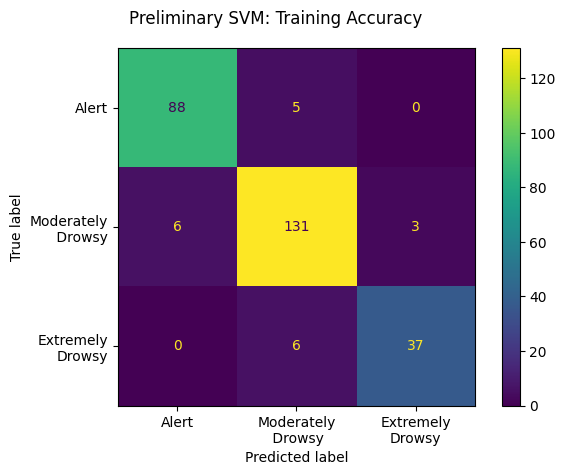

In [145]:
# Preliminary SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary SVM: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [146]:
# Training Accuracy
classwise_accuracy(clf_svm_prelim, X_train_scaled, y_train)

Accuracy of Alert: 94.6237%
Accuracy of Moderately Drowsy: 93.5714%
Accuracy of Extremely Drowsy: 86.0465%
----------------------------------------
Micro-average F1: 92.7536%
Weighted-average F1: 92.7310%
Macro-average F1: 92.0607%


{'class_accuracies': array([0.94623656, 0.93571429, 0.86046512]),
 'micro_f1': 0.927536231884058,
 'weighted_f1': 0.927310446188811,
 'macro_f1': 0.9206069166109577}

In [147]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_prelim, subject_train, subject_train, EEG_channel_train, X, X_train_scaled, y_train)
display(accuracy_df)

Accuracy of Alert: 94.6237%
Accuracy of Moderately Drowsy: 93.5714%
Accuracy of Extremely Drowsy: 86.0465%
----------------------------------------
Micro-average F1: 92.7536%
Weighted-average F1: 92.7310%
Macro-average F1: 92.0607%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=7)",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.946237,0.935714,0.860465,0.927536,0.92731,0.920607


* **Preliminary SVM: Testing Accuracy**

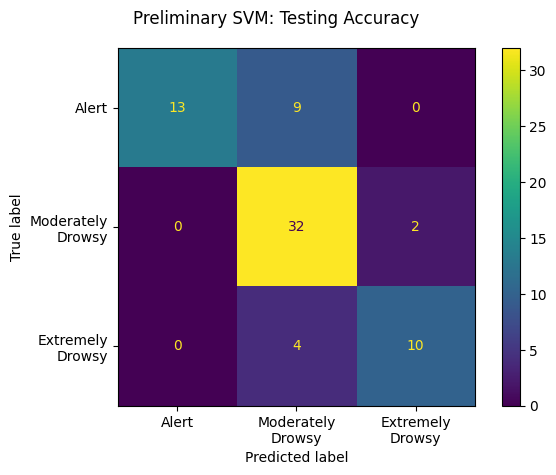

In [148]:
# Preliminary SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_svm_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [149]:
# Testing Accuracy
classwise_accuracy(clf_svm_prelim, X_test_scaled, y_test)

Accuracy of Alert: 59.0909%
Accuracy of Moderately Drowsy: 94.1176%
Accuracy of Extremely Drowsy: 71.4286%
----------------------------------------
Micro-average F1: 78.5714%
Weighted-average F1: 78.0806%
Macro-average F1: 77.4071%


{'class_accuracies': array([0.59090909, 0.94117647, 0.71428571]),
 'micro_f1': 0.7857142857142857,
 'weighted_f1': 0.7808055958508039,
 'macro_f1': 0.7740714981221309}

In [150]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_prelim, subject_train, subject_train, EEG_channel_train, X, X_test_scaled, y_test)
display(accuracy_df)

Accuracy of Alert: 59.0909%
Accuracy of Moderately Drowsy: 94.1176%
Accuracy of Extremely Drowsy: 71.4286%
----------------------------------------
Micro-average F1: 78.5714%
Weighted-average F1: 78.0806%
Macro-average F1: 77.4071%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=7)",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.946237,0.935714,0.860465,0.927536,0.927310,0.920607
1,"SVC(class_weight='balanced', random_state=7)",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.590909,0.941176,0.714286,0.785714,0.780806,0.774071


In [151]:
# Result Summary: Preliminary SVM (training)
result_summary(clf_svm_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
116,116,2.0,2.0,True
116,116,3.0,3.0,True
118,118,2.0,2.0,True
118,118,3.0,3.0,True


In [152]:
# Result Summary: Preliminary SVM (testing)
result_summary(clf_svm_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
6,6,1.0,1.0,True
8,8,1.0,1.0,True
9,9,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,2.0,True
117,117,3.0,3.0,True


##### **5.2 SVM + Optimized Parameters**

In [153]:
# Cross-Validation -> find parameters that maximize CV accuracy

param_grid = [
    {'C': [0.5, 1, 10, 100], # Regularization parameter must be > 0 #
     'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf', 'poly']},
]

optimal_params = GridSearchCV( 
    SVC(random_state=seed, class_weight='balanced'), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=1
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

best_cv_accuracy = optimal_params.best_score_
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8801


In [154]:
# Building, Evaluating, Drawing, Interpreting the Final SVM

# clf_svm_cv = SVC(random_state=seed, C=10, gamma='scale', kernel='rbf')
clf_svm_cv = SVC(random_state=seed, **optimal_params.best_params_, class_weight='balanced')
clf_svm_cv.fit(X_train_scaled, y_train)

SVC(C=10, class_weight='balanced', gamma=0.1, random_state=7)

In [155]:
print(clf_svm_cv.n_features_in_)
print(clf_svm_cv.class_weight_)
print(clf_svm_cv.__class__)
print(str(clf_svm_cv))
print(clf_svm_cv)
clf_svm_cv

17
[0.98924731 0.65714286 2.13953488]
<class 'sklearn.svm._classes.SVC'>
SVC(C=10, class_weight='balanced', gamma=0.1, random_state=7)
SVC(C=10, class_weight='balanced', gamma=0.1, random_state=7)


SVC(C=10, class_weight='balanced', gamma=0.1, random_state=7)

In [156]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_SupportVectorMachine_cv.pkl', "wb") as f:
    pickle.dump(clf_svm_cv, f)

* **Optimized SVM: Training Accuracy**

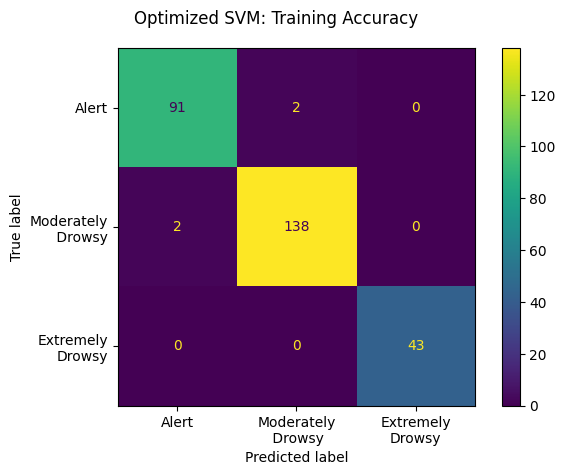

In [157]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Training Accuracy")
plt.tight_layout()
plt.show()

In [158]:
# Training Accuracy
classwise_accuracy(clf_svm_cv, X_train_scaled, y_train)

Accuracy of Alert: 97.8495%
Accuracy of Moderately Drowsy: 98.5714%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 98.5507%
Weighted-average F1: 98.5507%
Macro-average F1: 98.8070%


{'class_accuracies': array([0.97849462, 0.98571429, 1.        ]),
 'micro_f1': 0.9855072463768116,
 'weighted_f1': 0.9855072463768116,
 'macro_f1': 0.9880696364567333}

In [159]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_cv, subject_train, subject_train, EEG_channel_train, X, X_train_scaled, y_train)
display(accuracy_df)

Accuracy of Alert: 97.8495%
Accuracy of Moderately Drowsy: 98.5714%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 98.5507%
Weighted-average F1: 98.5507%
Macro-average F1: 98.8070%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=7)",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.946237,0.935714,0.860465,0.927536,0.927310,0.920607
1,"SVC(class_weight='balanced', random_state=7)",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.590909,0.941176,0.714286,0.785714,0.780806,0.774071
2,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.978495,0.985714,1.000000,0.985507,0.985507,0.988070


* **Optimized SVM: Testing Accuracy**

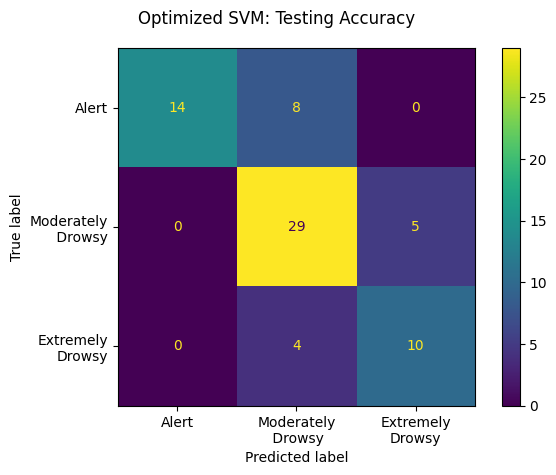

In [160]:
# Optimized SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Testing Accuracy")
plt.tight_layout()
plt.show()

In [161]:
# Testing Accuracy
classwise_accuracy(clf_svm_cv, X_test_scaled, y_test)

Accuracy of Alert: 63.6364%
Accuracy of Moderately Drowsy: 85.2941%
Accuracy of Extremely Drowsy: 71.4286%
----------------------------------------
Micro-average F1: 75.7143%
Weighted-average F1: 75.7995%
Macro-average F1: 74.6922%


{'class_accuracies': array([0.63636364, 0.85294118, 0.71428571]),
 'micro_f1': 0.7571428571428571,
 'weighted_f1': 0.7579945265462507,
 'macro_f1': 0.7469220945083014}

In [162]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_cv, subject_train, subject_train, EEG_channel_train, X, X_test_scaled, y_test)
display(accuracy_df)

Accuracy of Alert: 63.6364%
Accuracy of Moderately Drowsy: 85.2941%
Accuracy of Extremely Drowsy: 71.4286%
----------------------------------------
Micro-average F1: 75.7143%
Weighted-average F1: 75.7995%
Macro-average F1: 74.6922%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=7)",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.946237,0.935714,0.860465,0.927536,0.927310,0.920607
1,"SVC(class_weight='balanced', random_state=7)",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.590909,0.941176,0.714286,0.785714,0.780806,0.774071
2,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.978495,0.985714,1.000000,0.985507,0.985507,0.988070
3,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.636364,0.852941,0.714286,0.757143,0.757995,0.746922


In [163]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_svm_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
6,6,1.0,1.0,True
8,8,1.0,1.0,True
9,9,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,3.0,False
117,117,3.0,3.0,True


##### **5.3 SVM with PCA**

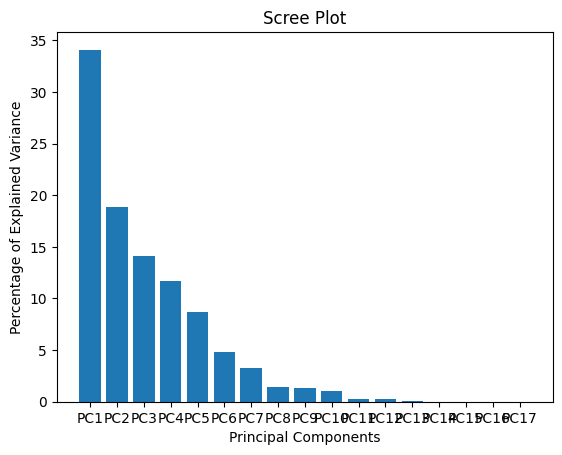

In [42]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
pca_transformer = pca.fit(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [43]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_pca_transformer.pkl', "wb") as f:
    pickle.dump(pca_transformer, f)

In [44]:
X.columns

Index(['Epoch_minute', 'Initial_KSS', 'DeltaRelative_2', 'ThetaRelative_2',
       'AlphaRelative_2', 'BetaRelative_2', 'AlphaBetaRatio_2', 'TA_BRatio_2',
       'DeltaRelative_3', 'ThetaRelative_3', 'AlphaRelative_3',
       'BetaRelative_3', 'AlphaBetaRatio_3', 'TA_BRatio_3', 'LFHF', 'pLF',
       'pHF'],
      dtype='object')

In [45]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=X.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

AlphaRelative_3     0.366849
ThetaRelative_3     0.340048
DeltaRelative_3    -0.334479
TA_BRatio_2         0.326747
BetaRelative_2     -0.298472
AlphaBetaRatio_2    0.294010
AlphaBetaRatio_3    0.252961
pHF                -0.244588
pLF                 0.244588
LFHF                0.243179
dtype: float64


In [46]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train = np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          ))

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))


pca_scaler = StandardScaler()

pca_train_standardscaled = pca_scaler.fit_transform(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))


In [47]:
pca_scaler_save = pca_scaler.fit(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))

with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_pca_scaler.pkl', "wb") as f:
    pickle.dump(pca_scaler_save, f)

In [170]:

param_grid = [
    {'C': [0.5, 1, 10, 100, 1000], # Note: Values for C must be > 0
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
     'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVC(random_state=seed, class_weight='balanced'), 
    param_grid,
    cv = 5, 
    scoring='accuracy', 
    verbose=0
)

optimal_params.fit(pca_train_standardscaled, y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [171]:
clf_svm_pca = SVC(random_state=seed, **optimal_params.best_params_, class_weight='balanced')
clf_svm_pca.fit(pca_train_standardscaled, y_train)

SVC(C=10, class_weight='balanced', random_state=7)

In [172]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_SupportVectorMachine_pca.pkl', "wb") as f:
    pickle.dump(clf_svm_pca, f)

In [173]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test = np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         ))

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

In [174]:
pca_test_standardscaled = pca_scaler.transform(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

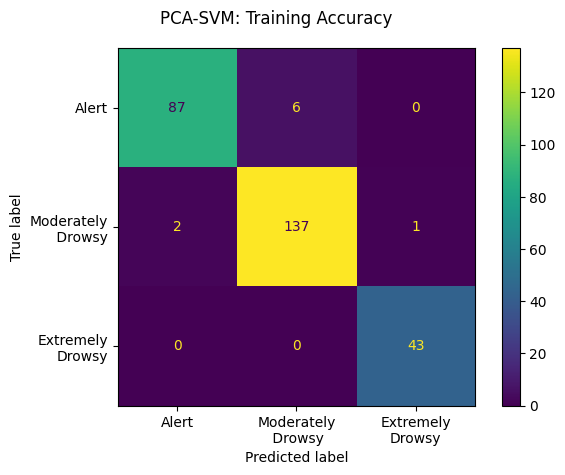

In [175]:
# PCA-SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_train_standardscaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-SVM: Training Accuracy")
plt.tight_layout()
plt.show()


In [176]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_svm_pca, pca_train_standardscaled, y_train)

Accuracy of Alert: 93.5484%
Accuracy of Moderately Drowsy: 97.8571%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 96.7391%
Weighted-average F1: 96.7266%
Macro-average F1: 97.0916%


{'class_accuracies': array([0.93548387, 0.97857143, 1.        ]),
 'micro_f1': 0.967391304347826,
 'weighted_f1': 0.9672664428215098,
 'macro_f1': 0.9709158610096833}

In [177]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_pca, subject_train, subject_train, EEG_channel_train, 'pca', pca_train_standardscaled, y_train)
display(accuracy_df)

Accuracy of Alert: 93.5484%
Accuracy of Moderately Drowsy: 97.8571%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 96.7391%
Weighted-average F1: 96.7266%
Macro-average F1: 97.0916%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=7)",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.946237,0.935714,0.860465,0.927536,0.927310,0.920607
1,"SVC(class_weight='balanced', random_state=7)",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.590909,0.941176,0.714286,0.785714,0.780806,0.774071
2,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.978495,0.985714,1.000000,0.985507,0.985507,0.988070
3,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.636364,0.852941,0.714286,0.757143,0.757995,0.746922
4,"SVC(C=10, class_weight='balanced', random_stat...",137,137,23,PCA,6,0.935484,0.978571,1.000000,0.967391,0.967266,0.970916


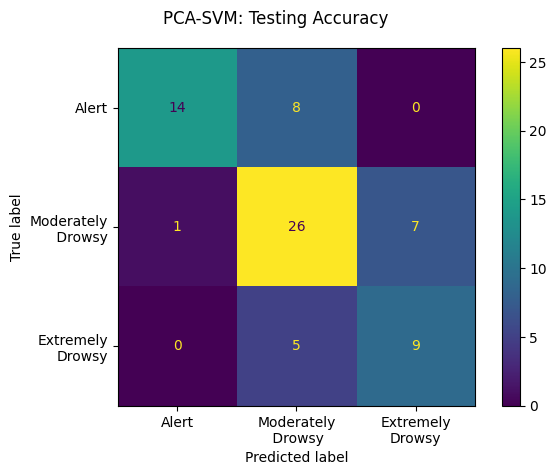

In [178]:
# PCA-SVM: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_test_standardscaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-SVM: Testing Accuracy")
plt.tight_layout()
plt.show()


In [179]:
# PCA-SVM: Testing Accuracy
classwise_accuracy(clf_svm_pca, pca_test_standardscaled, y_test)

Accuracy of Alert: 63.6364%
Accuracy of Moderately Drowsy: 76.4706%
Accuracy of Extremely Drowsy: 64.2857%
----------------------------------------
Micro-average F1: 70.0000%
Weighted-average F1: 70.3826%
Macro-average F1: 68.9695%


{'class_accuracies': array([0.63636364, 0.76470588, 0.64285714]),
 'micro_f1': 0.7,
 'weighted_f1': 0.7038260961548632,
 'macro_f1': 0.6896951746266815}

In [180]:
# accuracy_record(dataframe, model, subject_train, subject_test, X, X_test_scaled, y_test)
accuracy_df = accuracy_record(accuracy_df, clf_svm_pca, subject_train, subject_train, EEG_channel_train, 'pca', pca_test_standardscaled, y_test)
display(accuracy_df)

Accuracy of Alert: 63.6364%
Accuracy of Moderately Drowsy: 76.4706%
Accuracy of Extremely Drowsy: 64.2857%
----------------------------------------
Micro-average F1: 70.0000%
Weighted-average F1: 70.3826%
Macro-average F1: 68.9695%


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(class_weight='balanced', random_state=7)",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.946237,0.935714,0.860465,0.927536,0.927310,0.920607
1,"SVC(class_weight='balanced', random_state=7)",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.590909,0.941176,0.714286,0.785714,0.780806,0.774071
2,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.978495,0.985714,1.000000,0.985507,0.985507,0.988070
3,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,137,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.636364,0.852941,0.714286,0.757143,0.757995,0.746922
4,"SVC(C=10, class_weight='balanced', random_stat...",137,137,23,PCA,6,0.935484,0.978571,1.000000,0.967391,0.967266,0.970916
5,"SVC(C=10, class_weight='balanced', random_stat...",137,137,23,PCA,6,0.636364,0.764706,0.642857,0.700000,0.703826,0.689695


In [181]:
# Result Summary: SVM-PCA (training)
result_summary(clf_svm_pca, X_train, pca_train_standardscaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
116,116,2.0,2.0,True
116,116,3.0,3.0,True
118,118,2.0,2.0,True
118,118,3.0,3.0,True


In [182]:
# Result Summary: SVM-PCA (testing)
result_summary(clf_svm_pca, X_test, pca_test_standardscaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
3,3,1.0,1.0,True
6,6,1.0,1.0,True
8,8,1.0,1.0,True
9,9,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,3.0,False
117,117,3.0,2.0,False


## **6. K-Nearest Neighbors (KNN)**

##### **6.1 K-NN (Preliminary)**

In [235]:
import math
print(math.sqrt(len(y_train)))
print(math.sqrt(len(y_test)))

18.76166303929372
9.38083151964686


In [236]:
# classifier = KNeighborsClassifier(n_neighbors=3, p=3, metric='euclidean') # odd no. for n, 
clf_knn_prelim = KNeighborsClassifier()
clf_knn_prelim.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [237]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_KNearestNeighbors_prelim.pkl', "wb") as f:
    pickle.dump(clf_knn_prelim, f)

* **Preliminary KNN: Training Accuracy**

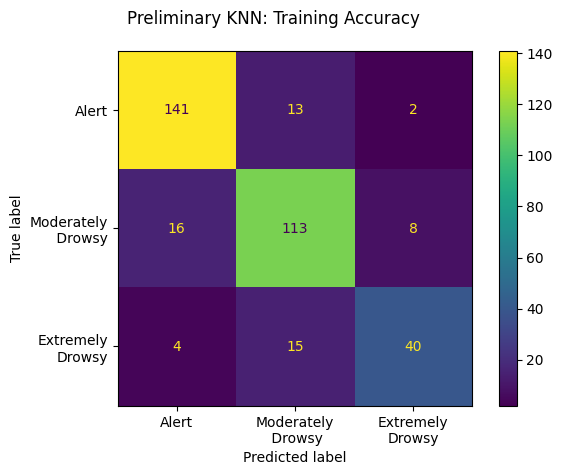

In [238]:
# Preliminary KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary KNN: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [239]:
# Training Accuracy
classwise_accuracy(clf_knn_prelim, X_train_scaled, y_train)

Accuracy of Alert: 90.3846%
Accuracy of Moderately Drowsy: 82.4818%
Accuracy of Extremely Drowsy: 67.7966%
----------------------------------------
Micro-average F1: 83.5227%
Weighted-average F1: 83.3673%
Macro-average F1: 81.2161%


* **Preliminary KNN: Testing Accuracy**

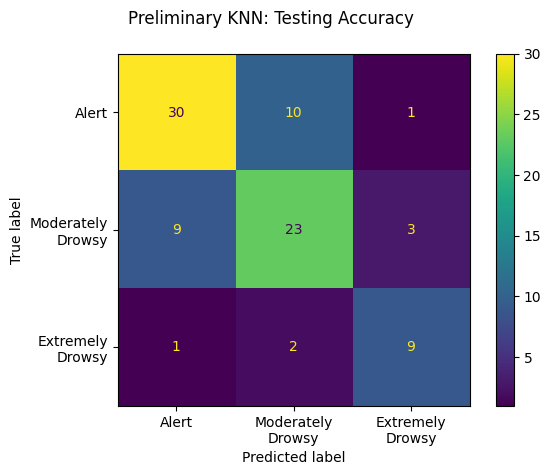

In [240]:
# Preliminary KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_knn_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary KNN: Testing Accuracy")
plt.tight_layout()
plt.show()

In [241]:
# Testing Accuracy
classwise_accuracy(clf_knn_prelim, X_test_scaled, y_test)

Accuracy of Alert: 73.1707%
Accuracy of Moderately Drowsy: 65.7143%
Accuracy of Extremely Drowsy: 75.0000%
----------------------------------------
Micro-average F1: 70.4545%
Weighted-average F1: 70.4663%
Macro-average F1: 70.5961%


In [242]:
# Result Summary: Preliminary KNN (training)
result_summary(clf_knn_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
117,117,2.0,2.0,True
117,117,2.0,2.0,True
118,118,2.0,2.0,True
118,118,2.0,2.0,True


In [243]:
# Result Summary: Preliminary KNN (testing)
result_summary(clf_knn_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,3.0,False
117,117,3.0,3.0,True


##### **6.2 K-NN + Optimized Parameters**

In [244]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1,26)),
    # [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 23],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

optimal_params = GridSearchCV(
    knn, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(X_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best cross-validation score: 0.7529979879275654


In [245]:
# classifier = KNeighborsClassifier(n_neighbors=3, p=3, metric='euclidean') # odd no. for n, 
clf_knn_cv = KNeighborsClassifier(**optimal_params.best_params_)
clf_knn_cv.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=10, weights='distance')

In [246]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_KNearestNeighbors_cv.pkl', "wb") as f:
    pickle.dump(clf_knn_cv, f)

* **Optimized KNN: Training Accuracy**

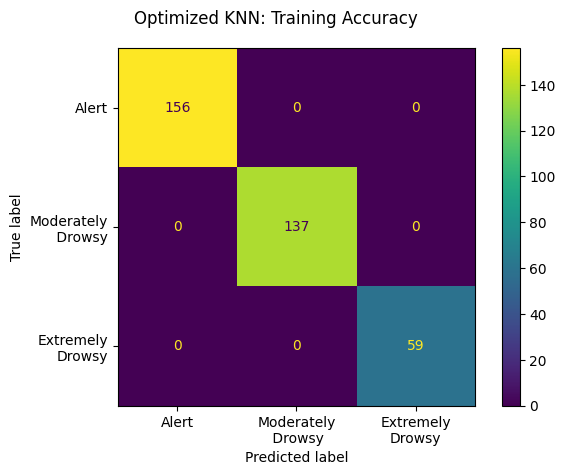

In [247]:
# Optimized KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized KNN: Training Accuracy")
plt.tight_layout()
plt.show()

In [248]:
# Training Accuracy
classwise_accuracy(clf_knn_cv, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Optimized KNN: Testing Accuracy**

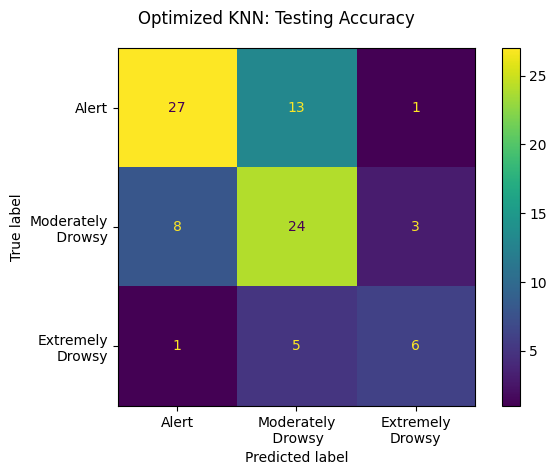

In [249]:
# Optimized KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized KNN: Testing Accuracy")
plt.tight_layout()
plt.show()

In [250]:
# Testing Accuracy
classwise_accuracy(clf_knn_cv, X_test_scaled, y_test)

Accuracy of Alert: 65.8537%
Accuracy of Moderately Drowsy: 68.5714%
Accuracy of Extremely Drowsy: 50.0000%
----------------------------------------
Micro-average F1: 64.7727%
Weighted-average F1: 64.9055%
Macro-average F1: 62.3377%


In [251]:
# Result Summary: Optimized SVM (training)
result_summary(clf_knn_cv, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
117,117,2.0,2.0,True
117,117,2.0,2.0,True
118,118,2.0,2.0,True
118,118,2.0,2.0,True


In [252]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_knn_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,3.0,False
117,117,3.0,2.0,False


##### **6.3 KNN with PCA**

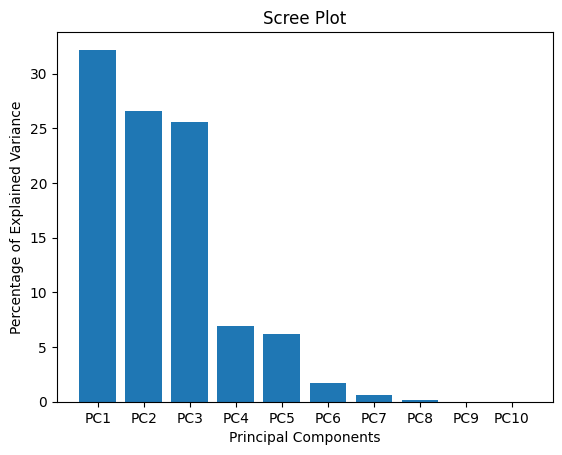

In [253]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [254]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=X.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

DeltaRelative     0.461281
BetaRelative     -0.416649
AlphaRelative    -0.372563
pHF               0.358432
pLF              -0.358432
LFHF             -0.317695
ThetaRelative    -0.275294
TA_BRatio         0.164894
Epoch_minute     -0.113357
AlphaBetaRatio    0.033413
dtype: float64


In [255]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))


In [256]:
param_grid = {
    'n_neighbors': list(range(1,26)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

optimal_params = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(pca_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best cross-validation score: 0.7758148893360162


In [257]:
clf_knn_pca = KNeighborsClassifier(**optimal_params.best_params_)
clf_knn_pca.fit(pca_train_scaled, y_train)

KNeighborsClassifier(weights='distance')

In [258]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_KNearestNeighbors_pca.pkl', "wb") as f:
    pickle.dump(clf_knn_pca, f)

In [259]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

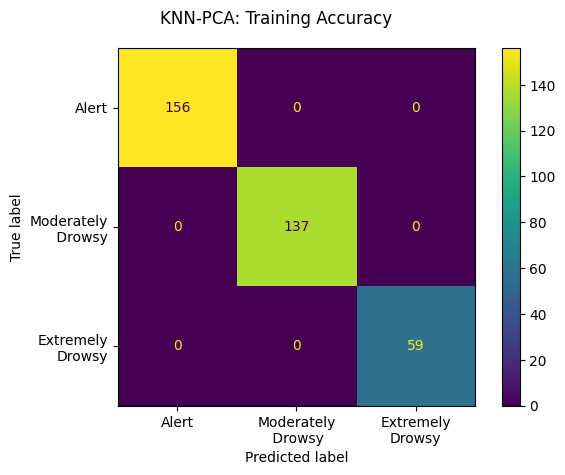

In [260]:
# PCA-KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("KNN-PCA: Training Accuracy")
plt.tight_layout()
plt.show()


In [261]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_knn_pca, pca_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


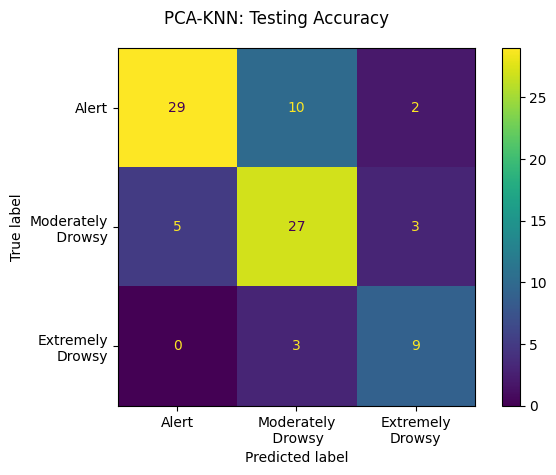

In [262]:
# PCA-KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-KNN: Testing Accuracy")
plt.tight_layout()
plt.show()


In [263]:
# PCA-KNN: Testing Accuracy
classwise_accuracy(clf_knn_pca, pca_test_scaled, y_test)

Accuracy of Alert: 70.7317%
Accuracy of Moderately Drowsy: 77.1429%
Accuracy of Extremely Drowsy: 75.0000%
----------------------------------------
Micro-average F1: 73.8636%
Weighted-average F1: 74.1072%
Macro-average F1: 72.8547%


In [264]:
# Result Summary: KNN-PCA (training)
result_summary(clf_knn_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
117,117,2.0,2.0,True
117,117,2.0,2.0,True
118,118,2.0,2.0,True
118,118,2.0,2.0,True


## **7. Decision Tree** 

##### **7.1 Decision Tree (Preliminary)**

In [265]:
clf_dt_prelim = DecisionTreeClassifier()
clf_dt_prelim.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [266]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_DecisionTree_prelim.pkl', "wb") as f:
    pickle.dump(clf_dt_prelim, f)

* **Preliminary DT: Training Accuracy**

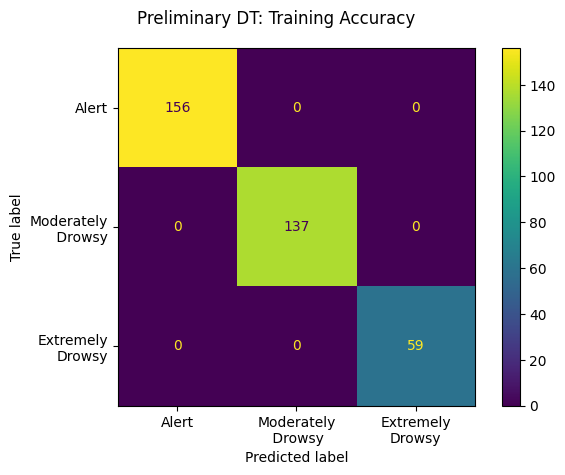

In [267]:
# Preliminary KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary DT: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [268]:
# Training Accuracy
classwise_accuracy(clf_dt_prelim, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Preliminary DT: Testing Accuracy**

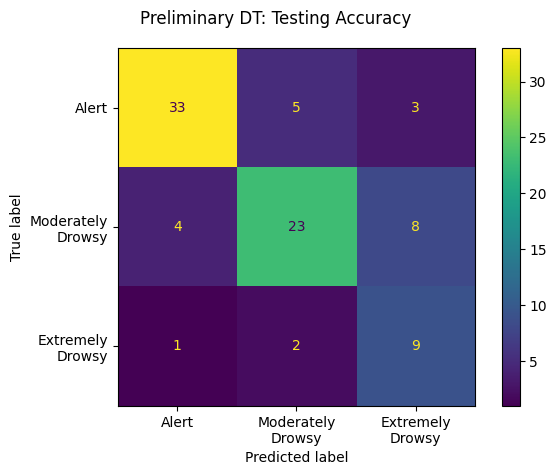

In [269]:
# Preliminary DT: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_dt_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary DT: Testing Accuracy")
plt.tight_layout()
plt.show()

In [270]:
# Testing Accuracy
classwise_accuracy(clf_dt_prelim, X_test_scaled, y_test)

Accuracy of Alert: 80.4878%
Accuracy of Moderately Drowsy: 65.7143%
Accuracy of Extremely Drowsy: 75.0000%
----------------------------------------
Micro-average F1: 73.8636%
Weighted-average F1: 74.7414%
Macro-average F1: 70.1878%


##### **7.2 Decision Tree + Optimized Parameters**

In [271]:
classifier = DecisionTreeClassifier()

param_grid = {
    'max_depth': range(2, 21),  # Explore depths from 2 to 20
    'min_samples_split': range(2, 11),  # Minimum samples for a split (2 to 10)
    'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
    'criterion': ['gini', 'entropy']  # Splitting criteria (gini or entropy)
}

optimal_params = GridSearchCV(
    classifier, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(X_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 1710 candidates, totalling 8550 fits
Best parameters: {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best cross-validation score: 0.8239034205231388


In [272]:
clf_dt_cv = DecisionTreeClassifier(**optimal_params.best_params_)
clf_dt_cv.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=2, min_samples_split=10)

In [273]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_DecisionTree_cv.pkl', "wb") as f:
    pickle.dump(clf_dt_cv, f)

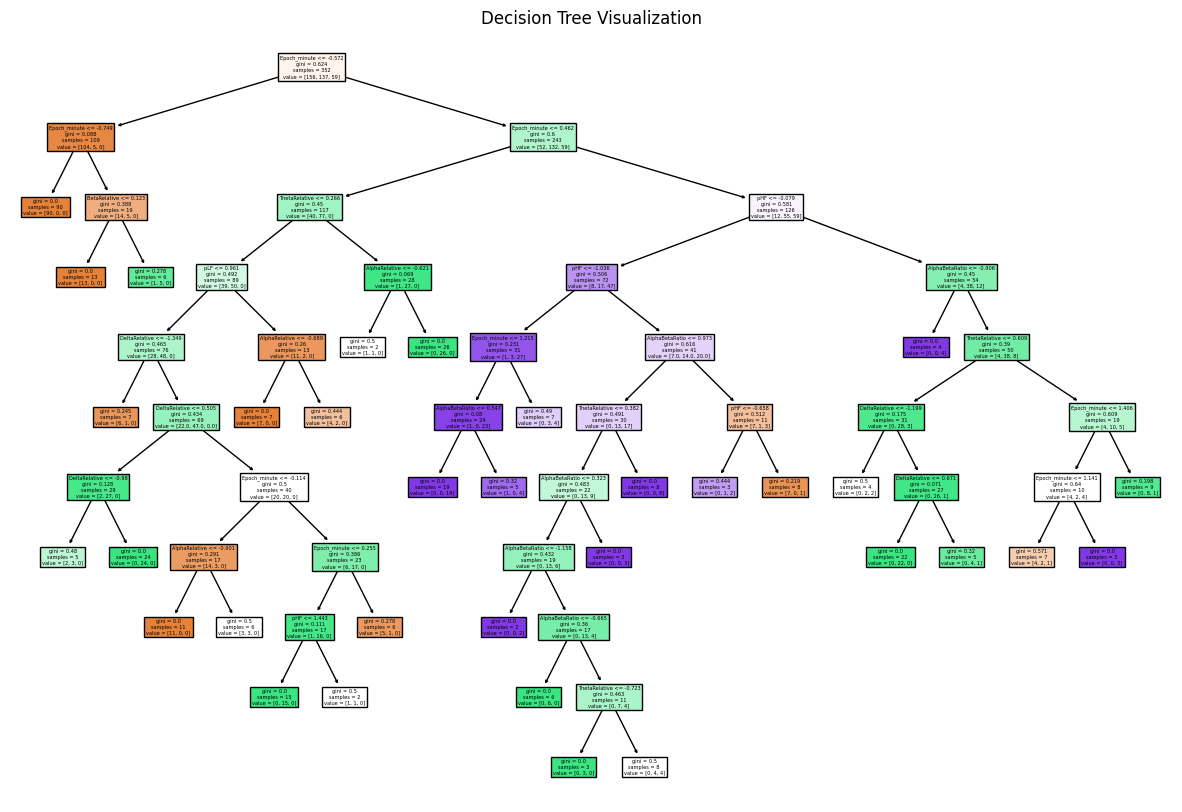

In [274]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(clf_dt_cv, ax = ax, feature_names = X.columns, filled = True)
plt.title("Decision Tree Visualization")
plt.show()

* **Optimized DT: Training Accuracy**

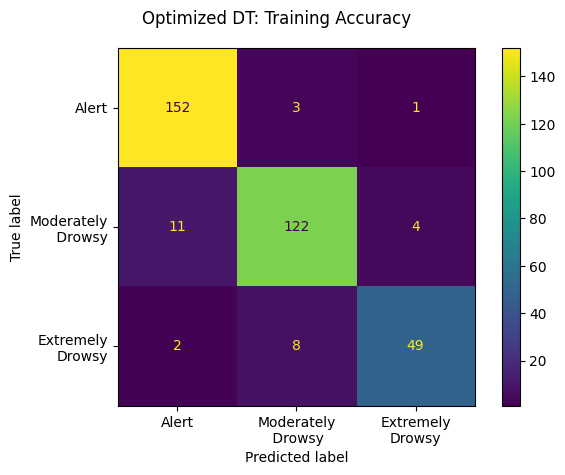

In [275]:
# Optimized KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized DT: Training Accuracy")
plt.tight_layout()
plt.show()

In [276]:
# Training Accuracy
classwise_accuracy(clf_dt_cv, X_train_scaled, y_train)

Accuracy of Alert: 97.4359%
Accuracy of Moderately Drowsy: 89.0511%
Accuracy of Extremely Drowsy: 83.0508%
----------------------------------------
Micro-average F1: 91.7614%
Weighted-average F1: 91.6801%
Macro-average F1: 90.6000%


* **Optimized DT: Testing Accuracy**

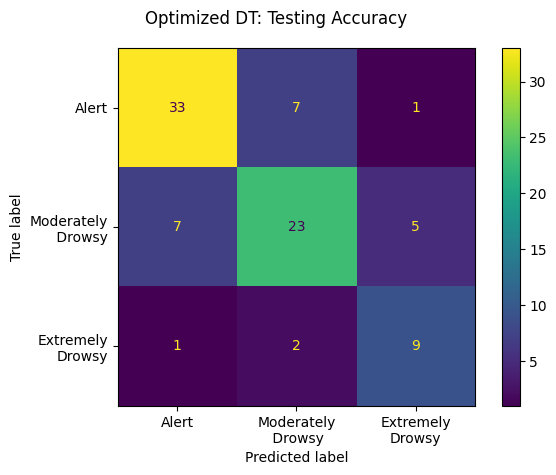

In [277]:
# Optimized DT: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized DT: Testing Accuracy")
plt.tight_layout()
plt.show()

In [278]:
# Testing Accuracy
classwise_accuracy(clf_dt_cv, X_test_scaled, y_test)

Accuracy of Alert: 80.4878%
Accuracy of Moderately Drowsy: 65.7143%
Accuracy of Extremely Drowsy: 75.0000%
----------------------------------------
Micro-average F1: 73.8636%
Weighted-average F1: 73.8976%
Macro-average F1: 71.9371%


In [279]:
# Result Summary: Optimized SVM (training)
result_summary(clf_dt_cv, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
117,117,2.0,2.0,True
117,117,2.0,2.0,True
118,118,2.0,2.0,True
118,118,2.0,2.0,True


In [280]:
# Result Summary: Optimized SVM (testing)
test_summary = result_summary(clf_dt_cv, X_test, X_test_scaled, y_test)

##### **7.3 Decision Tree with PCA**

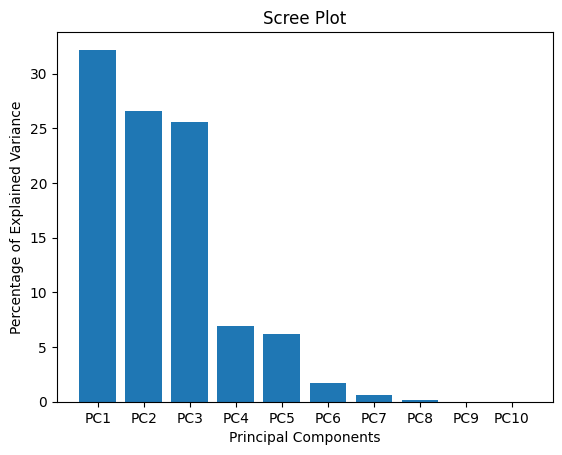

In [281]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [282]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=X.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

DeltaRelative     0.461281
BetaRelative     -0.416649
AlphaRelative    -0.372563
pHF               0.358432
pLF              -0.358432
LFHF             -0.317695
ThetaRelative    -0.275294
TA_BRatio         0.164894
Epoch_minute     -0.113357
AlphaBetaRatio    0.033413
dtype: float64


In [283]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))


In [284]:
classifier = DecisionTreeClassifier()

param_grid = {
    'max_depth': range(2, 21),  # Explore depths from 2 to 20
    'min_samples_split': range(2, 11),  # Minimum samples for a split (2 to 10)
    'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
    'criterion': ['gini', 'entropy']  # Splitting criteria (gini or entropy)
}

optimal_params = GridSearchCV(
    classifier, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1)


optimal_params.fit(pca_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 1710 candidates, totalling 8550 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score: 0.7075251509054326


In [285]:
clf_dt_pca = DecisionTreeClassifier(**optimal_params.best_params_)
clf_dt_pca.fit(pca_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=17, min_samples_split=5)

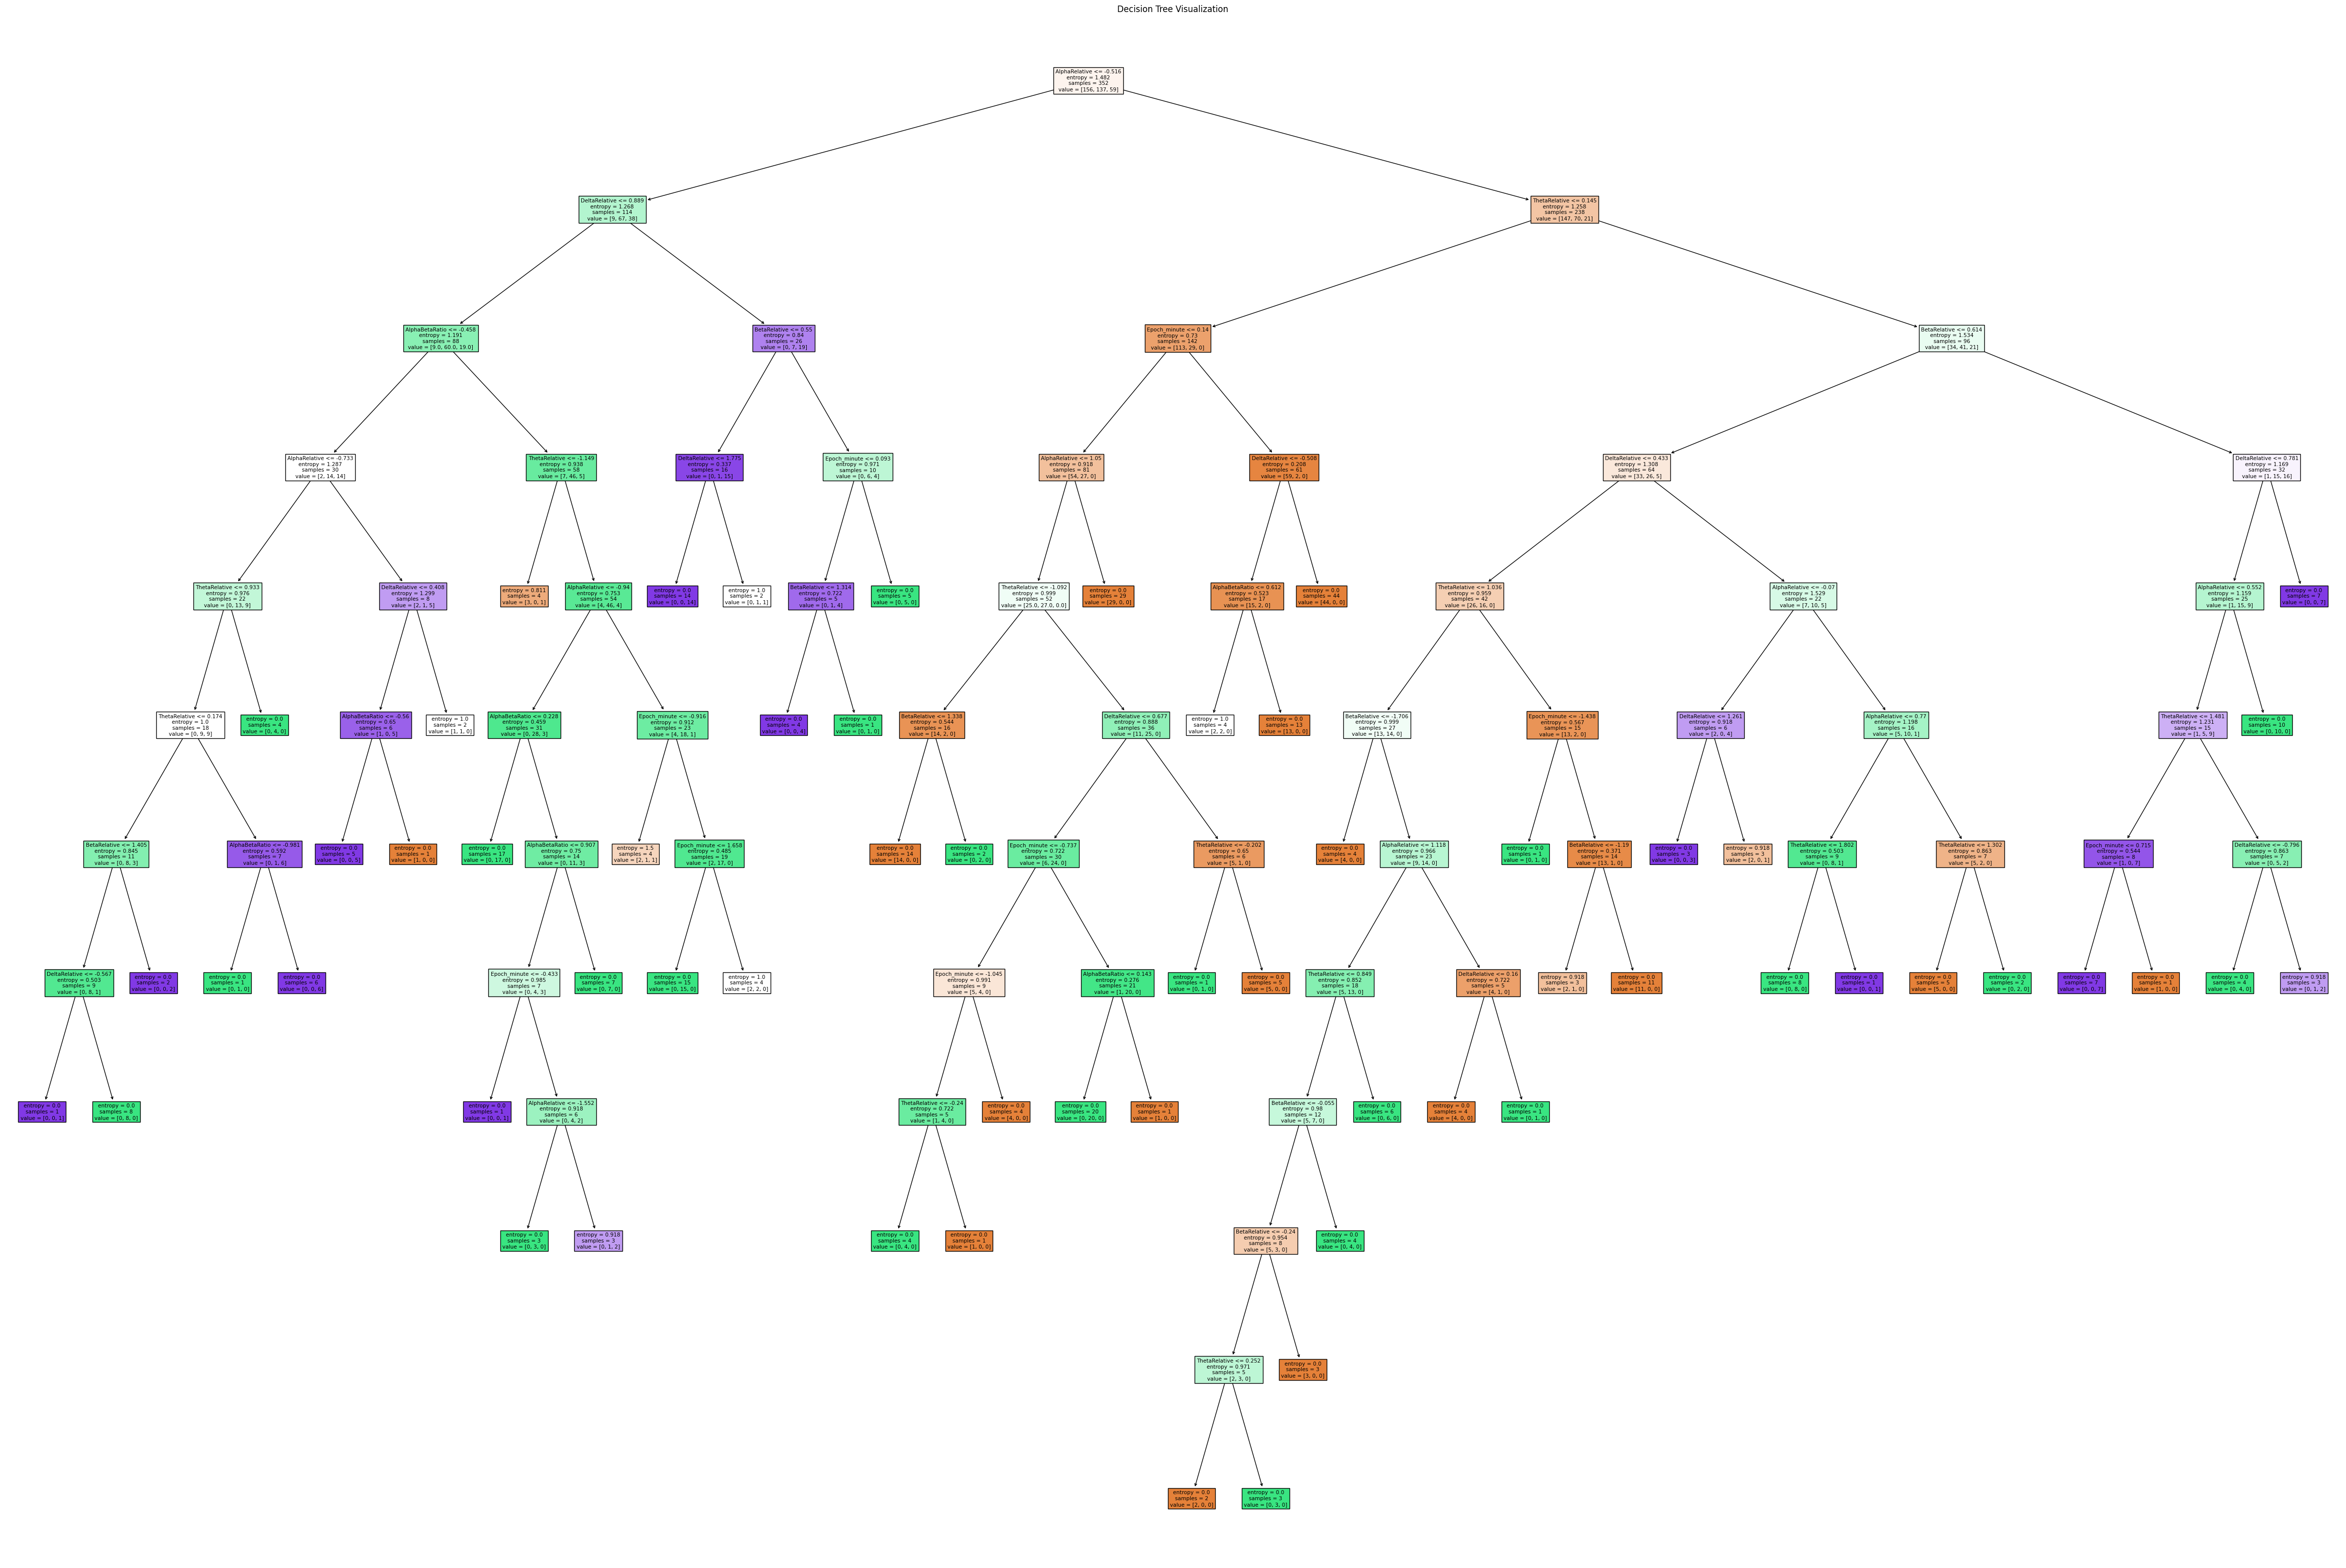

In [286]:
fig, ax = plt.subplots(figsize=(60, 40))
plot_tree(clf_dt_pca, ax = ax, feature_names = X.columns, filled = True)
plt.title("Decision Tree Visualization")
plt.show()

In [287]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_DecisionTree_pca.pkl', "wb") as f:
    pickle.dump(clf_dt_pca, f)

In [288]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

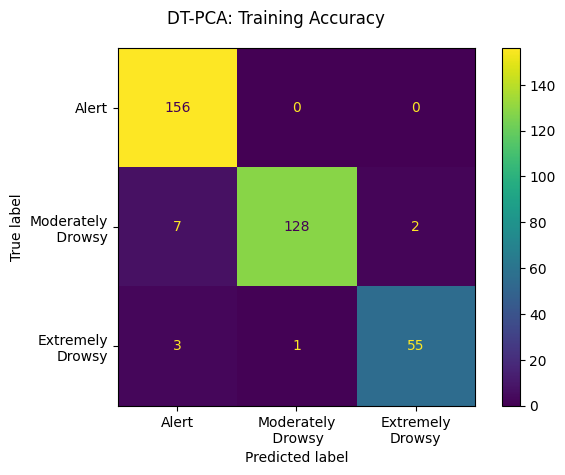

In [289]:
# PCA-KNN: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("DT-PCA: Training Accuracy")
plt.tight_layout()
plt.show()


In [290]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_dt_pca, pca_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 93.4307%
Accuracy of Extremely Drowsy: 93.2203%
----------------------------------------
Micro-average F1: 96.3068%
Weighted-average F1: 96.2935%
Macro-average F1: 95.9875%


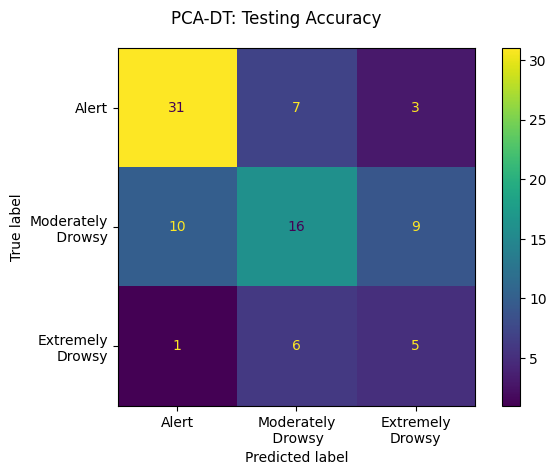

In [291]:
# PCA-KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-DT: Testing Accuracy")
plt.tight_layout()
plt.show()


In [292]:
# PCA-KNN: Testing Accuracy
classwise_accuracy(clf_dt_pca, pca_test_scaled, y_test)

Accuracy of Alert: 75.6098%
Accuracy of Moderately Drowsy: 45.7143%
Accuracy of Extremely Drowsy: 41.6667%
----------------------------------------
Micro-average F1: 59.0909%
Weighted-average F1: 59.3914%
Macro-average F1: 53.0605%


In [293]:
# Result Summary: KNN-PCA (training)
result_summary(clf_dt_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
117,117,2.0,2.0,True
117,117,2.0,2.0,True
118,118,2.0,2.0,True
118,118,2.0,2.0,True


## **8. Random Forest**

##### **8.1 Random Forest (Preliminary)**

In [294]:
clf_rf_prelim = RandomForestClassifier()
clf_rf_prelim.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [295]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_RandomForest_prelim.pkl', "wb") as f:
    pickle.dump(clf_rf_prelim, f)

* **Preliminary RF: Training Accuracy**

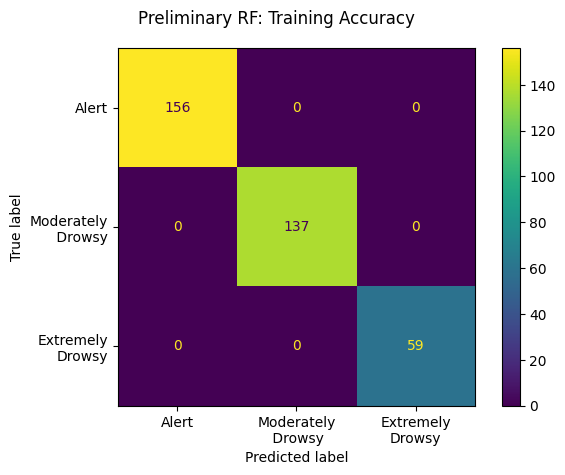

In [296]:
# Preliminary RF: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_prelim, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Preliminary RF: Training Accuracy")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [297]:
# Training Accuracy
classwise_accuracy(clf_rf_prelim, X_train_scaled, y_train)

Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 100.0000%
Accuracy of Extremely Drowsy: 100.0000%
----------------------------------------
Micro-average F1: 100.0000%
Weighted-average F1: 100.0000%
Macro-average F1: 100.0000%


* **Preliminary RF: Testing Accuracy**

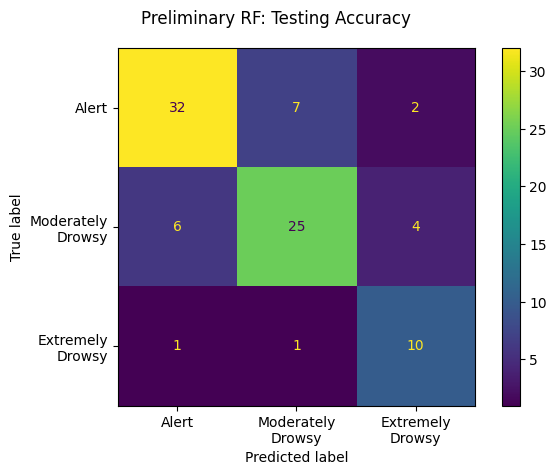

In [298]:
# Preliminary RF: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Testing = ConfusionMatrixDisplay.from_estimator(clf_rf_prelim, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\nDrowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Testing.figure_.suptitle("Preliminary RF: Testing Accuracy")
plt.tight_layout()
plt.show()

In [299]:
# Testing Accuracy
classwise_accuracy(clf_rf_prelim, X_test_scaled, y_test)

Accuracy of Alert: 78.0488%
Accuracy of Moderately Drowsy: 71.4286%
Accuracy of Extremely Drowsy: 83.3333%
----------------------------------------
Micro-average F1: 76.1364%
Weighted-average F1: 76.2576%
Macro-average F1: 74.9860%


In [300]:
# Result Summary: Preliminary RF (training)
result_summary(clf_rf_prelim, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
117,117,2.0,2.0,True
117,117,2.0,2.0,True
118,118,2.0,2.0,True
118,118,2.0,2.0,True


In [301]:
# Result Summary: Preliminary rf (testing)
result_summary(clf_rf_prelim, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,3.0,False
117,117,3.0,3.0,True


##### **8.2 Random Forest + Optimized Parameters**

In [302]:
param_grid = {
  'n_estimators': [100],  # Number of trees in the forest
  'max_depth': range(2, 5),  # Explore depths from 2 to 20
  'min_samples_split': range(2, 5),  # Minimum samples for a split (2 to 10)
  'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
  'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Create a RandomForestClassifier object
clf = RandomForestClassifier()

# Use GridSearchCV for hyperparameter tuning
optimal_params = GridSearchCV(
    clf,  # Use RandomForestClassifier here
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as scoring metric
    verbose=1,  # Print progress during search
    # estimator=tqdm(clf)
)

optimal_params.fit(X_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.7701810865191148


In [303]:
# classifier = KNeighborsClassifier(n_neighbors=3, p=3, metric='euclidean') # odd no. for n, 
clf_rf_cv = RandomForestClassifier(**optimal_params.best_params_)
clf_rf_cv.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=2)

In [304]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_RandomForest_cv.pkl', "wb") as f:
    pickle.dump(clf_rf_cv, f)

* **Optimized RF: Training Accuracy**

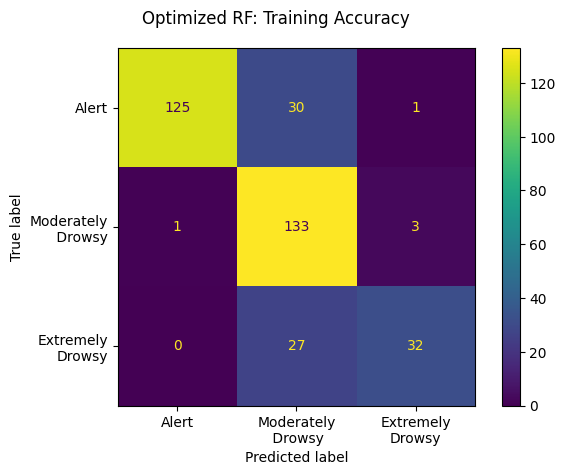

In [305]:
# Optimized RF: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_cv, 
                      X_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized RF: Training Accuracy")
plt.tight_layout()
plt.show()

In [306]:
# Training Accuracy
classwise_accuracy(clf_rf_cv, X_train_scaled, y_train)

Accuracy of Alert: 80.1282%
Accuracy of Moderately Drowsy: 97.0803%
Accuracy of Extremely Drowsy: 54.2373%
----------------------------------------
Micro-average F1: 82.3864%
Weighted-average F1: 82.2411%
Macro-average F1: 79.1222%


* **Optimized RF: Testing Accuracy**

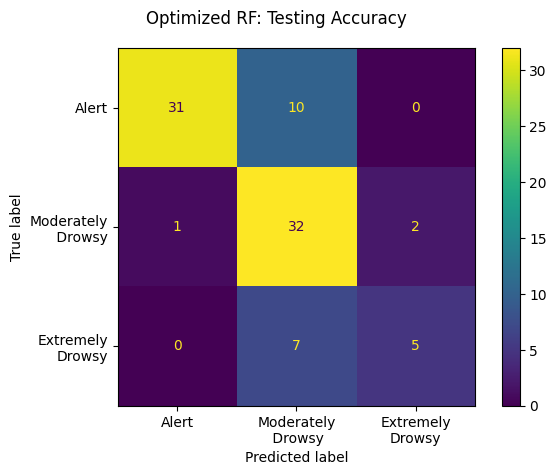

In [307]:
# Optimized KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_cv, 
                      X_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized RF: Testing Accuracy")
plt.tight_layout()
plt.show()

In [308]:
# Testing Accuracy
classwise_accuracy(clf_rf_cv, X_test_scaled, y_test)

Accuracy of Alert: 75.6098%
Accuracy of Moderately Drowsy: 91.4286%
Accuracy of Extremely Drowsy: 41.6667%
----------------------------------------
Micro-average F1: 77.2727%
Weighted-average F1: 77.0504%
Macro-average F1: 71.2512%


In [309]:
# Result Summary: Optimized SVM (training)
result_summary(clf_rf_cv, X_train, X_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
117,117,2.0,2.0,True
117,117,2.0,2.0,True
118,118,2.0,2.0,True
118,118,2.0,2.0,True


In [310]:
# Result Summary: Optimized SVM (testing)
result_summary(clf_rf_cv, X_test, X_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,3.0,False
117,117,3.0,2.0,False


##### **8.3 Random Forest with PCA**

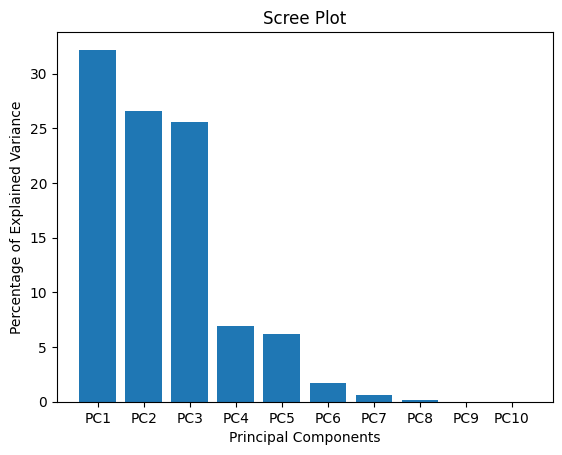

In [311]:
# PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks()
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [312]:
# Examine the Loading Scores of Principal Components

loading_scores = pd.Series(pca.components_[0], index=X.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_features = sorted_loading_scores[0:10].index.values

print(loading_scores[top_10_features])

DeltaRelative     0.461281
BetaRelative     -0.416649
AlphaRelative    -0.372563
pHF               0.358432
pLF              -0.358432
LFHF             -0.317695
ThetaRelative    -0.275294
TA_BRatio         0.164894
Epoch_minute     -0.113357
AlphaBetaRatio    0.033413
dtype: float64


In [313]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]
train_pc3_coords = X_train_pca[:, 2]
train_pc4_coords = X_train_pca[:, 3]
train_pc5_coords = X_train_pca[:, 4]
train_pc6_coords = X_train_pca[:, 5]
# train_pc7_coords = X_train_pca[:, 6]
# train_pc8_coords = X_train_pca[:, 7]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis cooridnates of the data after PCA

pca_train_scaled = scale(np.column_stack((train_pc1_coords, 
                                          train_pc2_coords, 
                                          train_pc3_coords, 
                                          train_pc4_coords, 
                                          train_pc5_coords, 
                                          train_pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))

In [314]:
param_grid = {
  'n_estimators': [100],  # Number of trees in the forest
  'max_depth': range(2, 5),  # Explore depths from 2 to 20
  'min_samples_split': range(2, 5),  # Minimum samples for a split (2 to 10)
  'min_samples_leaf': range(1, 6),   # Minimum samples required at each leaf (1 to 5)
  'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Create a RandomForestClassifier object
clf = RandomForestClassifier()

# Use GridSearchCV for hyperparameter tuning
optimal_params = GridSearchCV(
    clf,  # Use RandomForestClassifier here
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as scoring metric
    verbose=1,  # Print progress during search

)

optimal_params.fit(pca_train_scaled, y_train)

print("Best parameters:", optimal_params.best_params_)
print("Best cross-validation score:", optimal_params.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.684989939637827


In [315]:
clf_rf_pca = RandomForestClassifier(**optimal_params.best_params_)
clf_rf_pca.fit(pca_train_scaled, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=2)

In [316]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{''.join(str(x) for x in subject_list)}_RandomForest_pca.pkl', "wb") as f:
    pickle.dump(clf_rf_pca, f)

In [317]:
# Transform the test dataset with the PCA
# x_test_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]
test_pc3_coords = X_test_pca[:, 2]
test_pc4_coords = X_test_pca[:, 3]
test_pc5_coords = X_test_pca[:, 4]
test_pc6_coords = X_test_pca[:, 5]
# test_pc7_coords = X_test_pca[:, 6]
# test_pc8_coords = X_test_pca[:, 7]

pca_test_scaled = scale(np.column_stack((test_pc1_coords, 
                                         test_pc2_coords, 
                                         test_pc3_coords, 
                                         test_pc4_coords,
                                         test_pc5_coords, 
                                         test_pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

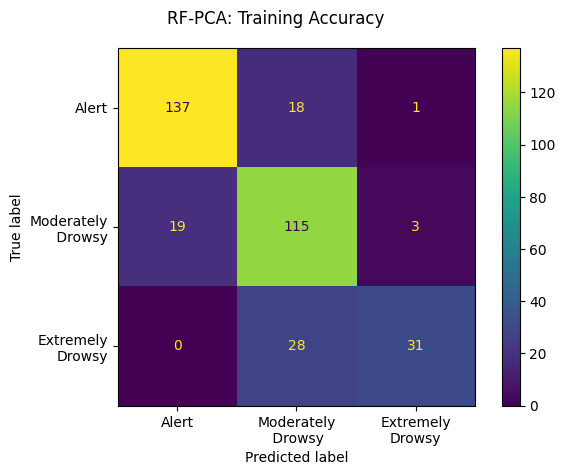

In [318]:
# PCA-RF: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_pca, 
                      pca_train_scaled, 
                      y_train,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("RF-PCA: Training Accuracy")
plt.tight_layout()
plt.show()


In [319]:
# PCA-RF: Training Accuracy
classwise_accuracy(clf_rf_pca, pca_train_scaled, y_train)

Accuracy of Alert: 87.8205%
Accuracy of Moderately Drowsy: 83.9416%
Accuracy of Extremely Drowsy: 52.5424%
----------------------------------------
Micro-average F1: 80.3977%
Weighted-average F1: 80.0151%
Macro-average F1: 76.9864%


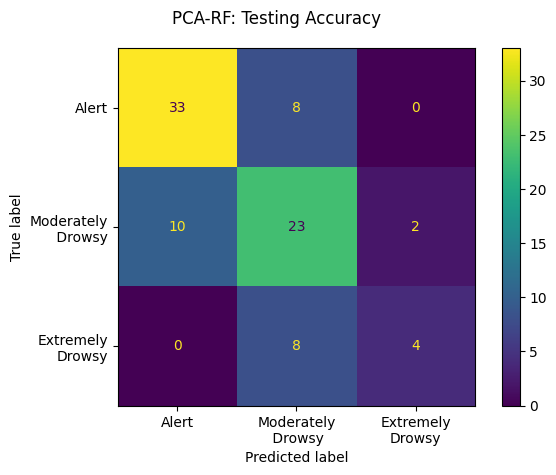

In [320]:
# PCA-KNN: Testing Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_pca, 
                      pca_test_scaled, 
                      y_test,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-RF: Testing Accuracy")
plt.tight_layout()
plt.show()


In [321]:
# PCA-KNN: Testing Accuracy
classwise_accuracy(clf_rf_pca, pca_test_scaled, y_test)

Accuracy of Alert: 80.4878%
Accuracy of Moderately Drowsy: 65.7143%
Accuracy of Extremely Drowsy: 33.3333%
----------------------------------------
Micro-average F1: 68.1818%
Weighted-average F1: 67.3913%
Macro-average F1: 61.7260%


In [322]:
# Result Summary: RF-PCA (training)
result_summary(clf_rf_pca, X_train, pca_train_scaled, y_train)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
0,0,1.0,1.0,True
1,1,1.0,1.0,True
...,...,...,...,...
117,117,2.0,2.0,True
117,117,2.0,2.0,True
118,118,2.0,2.0,True
118,118,2.0,2.0,True


In [323]:
# Result Summary: KNN-PCA (testing)
result_summary(clf_rf_pca, X_test, pca_test_scaled, y_test)

,Original Index,Original Label,Predicted Label,True/False
2,2,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,3.0,False
117,117,3.0,2.0,False
